In [1]:
from VisionEngine.datasets import guppies
from VisionEngine.utils.config import process_config
from VisionEngine.utils import factory
import sys
import os
from PIL import Image
from itertools import product
from dotenv import load_dotenv
from pathlib import Path

import numpy as np
import scipy

import numba

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

from sklearn.metrics import pairwise_distances
from tensorflow.keras.applications import VGG16
from tensorflow.keras import Model

from openTSNE import TSNE
from openTSNE.sklearn import TSNE as sklTSNE
from openTSNE.callbacks import ErrorLogger

import sys
import math

import tensorflow as tf
from tensorflow.keras.layers import Flatten

In [2]:
GPU = 1

In [18]:
# some plotting params
plt.rcParams['pdf.use14corefonts'] = True

In [4]:
env_path = Path('../') / '.env'
load_dotenv(dotenv_path=env_path)

True

In [5]:
checkpoint_path = "/home/etheredge/Workspace/VisionEngine/checkpoints/butterflies_nouveau/2020-229-11/butterflies_nouveau.hdf5"

In [6]:
config_file = "/home/etheredge/Workspace/VisionEngine/VisionEngine/configs/butterfly_nouveau_config.json"
config = process_config(config_file)

In [7]:
# config.data_loader.use_generated = False  

In [8]:
config.data_loader.use_generated = False
config.data_loader.use_real = True

config.data_loader.shuffle = False
config.data_loader.cache = True

In [9]:
data_loader = factory.create(
            "VisionEngine.data_loaders."+config.data_loader.name
            )(config)

importing VisionEngine.data_loaders.vae_data_loader
getattr DataLoader


In [10]:
with tf.device(f'/device:GPU:{GPU}'):
    model = factory.create(
            "VisionEngine.models."+config.model.name
            )(config)

importing VisionEngine.models.nouveau_vae_model
getattr VAEModel
Model: "vlae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
noise_layer (Sequential)        (None, 256, 256, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
encoder (Model)                 [(None, 524288), (No 38380171    noise_layer[0][0]                
__________________________________________________________________________________________________
variational_layer (VariationalL (None, 10)           5242890     encoder[1][0]                    
______________________________

In [11]:
model.load(checkpoint_path)

Loading model checkpoint /home/etheredge/Workspace/VisionEngine/checkpoints/butterflies_nouveau/2020-229-11/butterflies_nouveau.hdf5 ...

Model loaded


In [14]:
class LikeLihoodLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(LikeLihoodLayer, self).__init__(**kwargs)
        self.model_input_shape = [256, 256, 3]

    def build(self, input_shape):
        super(LikeLihoodLayer, self).build(input_shape)

    def call(self, layer_inputs, **kwargs):
        inputs, outputs = layer_inputs
        mse = - tf.losses.mean_squared_error(inputs, outputs)
        out = 1./(tf.sqrt(2.*math.pi))*tf.exp(-.5*(mse)**2.)
        return out

        return [y_true, y_pred]
    def compute_output_shape(self, input_shape):
        return input_shape[0]

    def get_config(self):
        config = {}
        base_config = \
            super(LikeLihoodLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

def sample_likelihood(x):
    inputs = Flatten()(model.model.input)
    outputs = Flatten()(model.model.output)
    out = LikeLihoodLayer()([inputs, outputs])
    lh_model = Model(model.model.input, out)
    return lh_model.predict(x)

def embed_images(x):
    outputs = [
        model.model.get_layer('variational_layer').output,
        model.model.get_layer('variational_layer_1').output,
        model.model.get_layer('variational_layer_2').output,
        model.model.get_layer('variational_layer_3').output
    ]
    encoder = Model(model.model.inputs, outputs)
    return encoder.predict(x)

def reconstruct_images(x):
    return model.model.predict(x)

def imscatter(x, y, image, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca();
    try:
        image = plt.imread(image);
    except TypeError:
        # Likely already an array...
        pass
    x, y = np.atleast_1d(x, y);
    artists = [];
    for i, (x0, y0) in enumerate(zip(x, y)):
        im = OffsetImage(image[i], zoom=zoom);
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False);
        artists.append(ax.add_artist(ab));
    ax.update_datalim(np.column_stack([x, y]));
    ax.autoscale();
    ax.grid(False);
    return artists

In [15]:
with tf.device(f'/device:GPU:{GPU}'):
    z = embed_images(data_loader.get_test_data())
# vision_engine_embedding = TSNE(callbacks=ErrorLogger(), n_jobs=-1).fit(np.concatenate([z[0], z[1], z[2], z[3]],axis=1))

In [16]:
with tf.device(f'/device:GPU:{GPU}'):
    labels = []
    images = []
    for image, label in data_loader.get_plot_data():
        labels.append(label.numpy().decode('utf8'))
        images.append(image.numpy().astype('uint8'))
    images = np.stack(images)
    labels = np.array(labels)

In [43]:
randoms = np.random.choice(range(len(z[0])), 8)

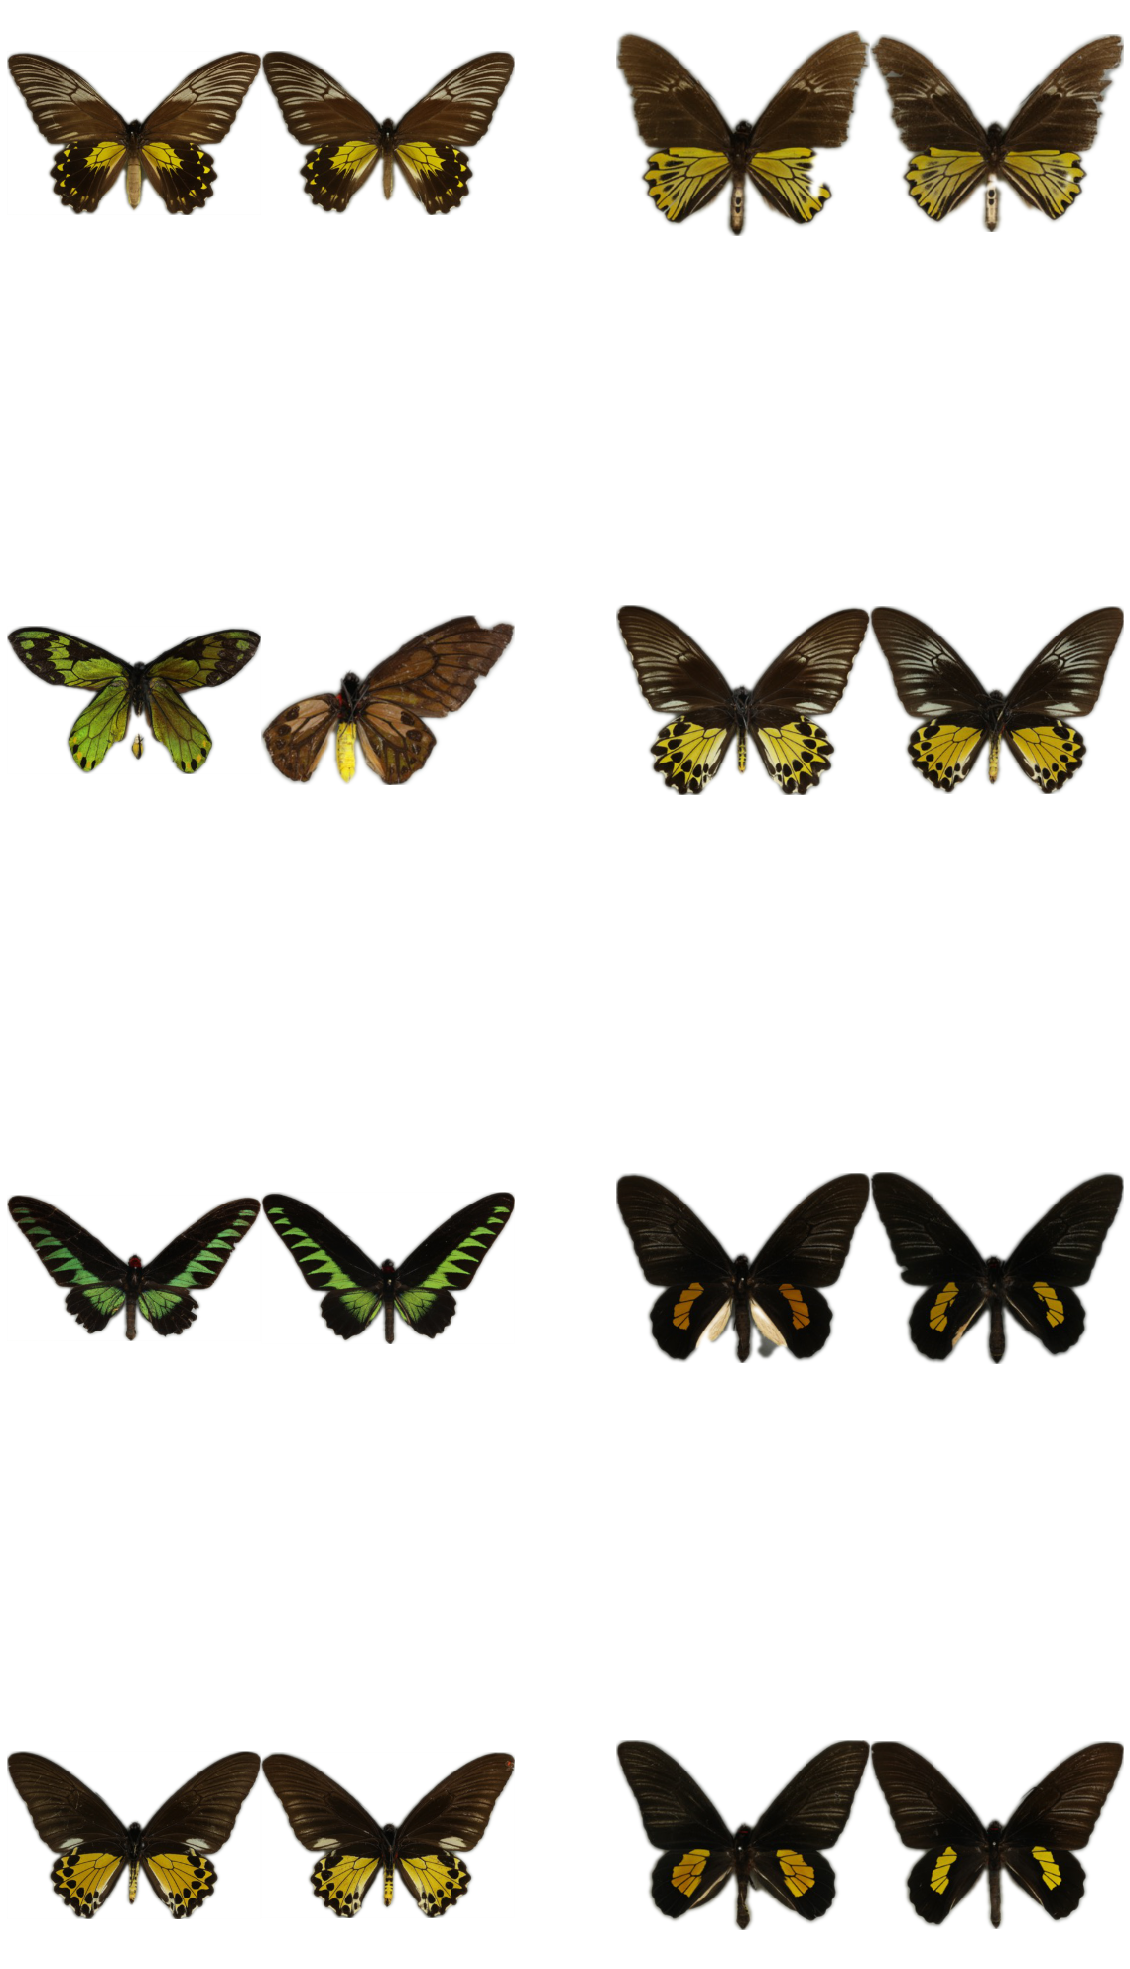

In [44]:
from sklearn.neighbors import NearestNeighbors
from scipy import spatial

Z = z[0]

tree = NearestNeighbors(
    n_neighbors=1, algorithm='ball_tree',
    metric='minkowski')
tree.fit(Z)

plt.figure(figsize=(20,40))

plt.subplot(421)
i = randoms[0]
image_container_orig = Image.new('RGBA', (256*2,256))
neighs = tree.kneighbors([Z[i]],2, return_distance=False)
img = images[neighs[0][0]]
neighbor = images[neighs[0][1]]
image_container_orig.paste(Image.fromarray(img), (0, 0))
image_container_orig.paste(Image.fromarray(neighbor), (256, 0))
plt.imshow(image_container_orig)
plt.axis('off')
    
plt.subplot(422)
i = randoms[1]
image_container_orig = Image.new('RGBA', (256*2,256))
neighs = tree.kneighbors([Z[i]],2, return_distance=False)
img = images[neighs[0][0]]
neighbor = images[neighs[0][1]]
image_container_orig.paste(Image.fromarray(img), (0, 0))
image_container_orig.paste(Image.fromarray(neighbor), (256, 0))
plt.imshow(image_container_orig)
plt.axis('off')

plt.subplot(423)
i = randoms[2]
image_container_orig = Image.new('RGBA', (256*2,256))
neighs = tree.kneighbors([Z[i]],2, return_distance=False)
img = images[neighs[0][0]]
neighbor = images[neighs[0][1]]
image_container_orig.paste(Image.fromarray(img), (0, 0))
image_container_orig.paste(Image.fromarray(neighbor), (256, 0))
plt.imshow(image_container_orig)
plt.axis('off')

plt.subplot(424)
i = randoms[3]
image_container_orig = Image.new('RGBA', (256*2,256))
neighs = tree.kneighbors([Z[i]],2, return_distance=False)
img = images[neighs[0][0]]
neighbor = images[neighs[0][1]]
image_container_orig.paste(Image.fromarray(img), (0, 0))
image_container_orig.paste(Image.fromarray(neighbor), (256, 0))
plt.imshow(image_container_orig)
plt.axis('off')

plt.subplot(425)
i = randoms[4]
image_container_orig = Image.new('RGBA', (256*2,256))
neighs = tree.kneighbors([Z[i]],2, return_distance=False)
img = images[neighs[0][0]]
neighbor = images[neighs[0][1]]
image_container_orig.paste(Image.fromarray(img), (0, 0))
image_container_orig.paste(Image.fromarray(neighbor), (256, 0))
plt.imshow(image_container_orig)
plt.axis('off')

plt.subplot(426)
i = randoms[5]
image_container_orig = Image.new('RGBA', (256*2,256))
neighs = tree.kneighbors([Z[i]],2, return_distance=False)
img = images[neighs[0][0]]
neighbor = images[neighs[0][1]]
image_container_orig.paste(Image.fromarray(img), (0, 0))
image_container_orig.paste(Image.fromarray(neighbor), (256, 0))
plt.imshow(image_container_orig)
plt.axis('off')

plt.subplot(427)
i = randoms[6]
image_container_orig = Image.new('RGBA', (256*2,256))
neighs = tree.kneighbors([z[0][i]],2, return_distance=False)
img = images[neighs[0][0]]
neighbor = images[neighs[0][1]]
image_container_orig.paste(Image.fromarray(img), (0, 0))
image_container_orig.paste(Image.fromarray(neighbor), (256, 0))
plt.imshow(image_container_orig)
plt.axis('off')

plt.subplot(428)
i = randoms[7]
image_container_orig = Image.new('RGBA', (256*2,256))
neighs = tree.kneighbors([Z[i]],2, return_distance=False)
img = images[neighs[0][0]]
neighbor = images[neighs[0][1]]
image_container_orig.paste(Image.fromarray(img), (0, 0))
image_container_orig.paste(Image.fromarray(neighbor), (256, 0))
plt.imshow(image_container_orig)
plt.axis('off')

fig = plt.gcf()
fig.savefig('NN_z0_bflies_2.png', dpi=300)

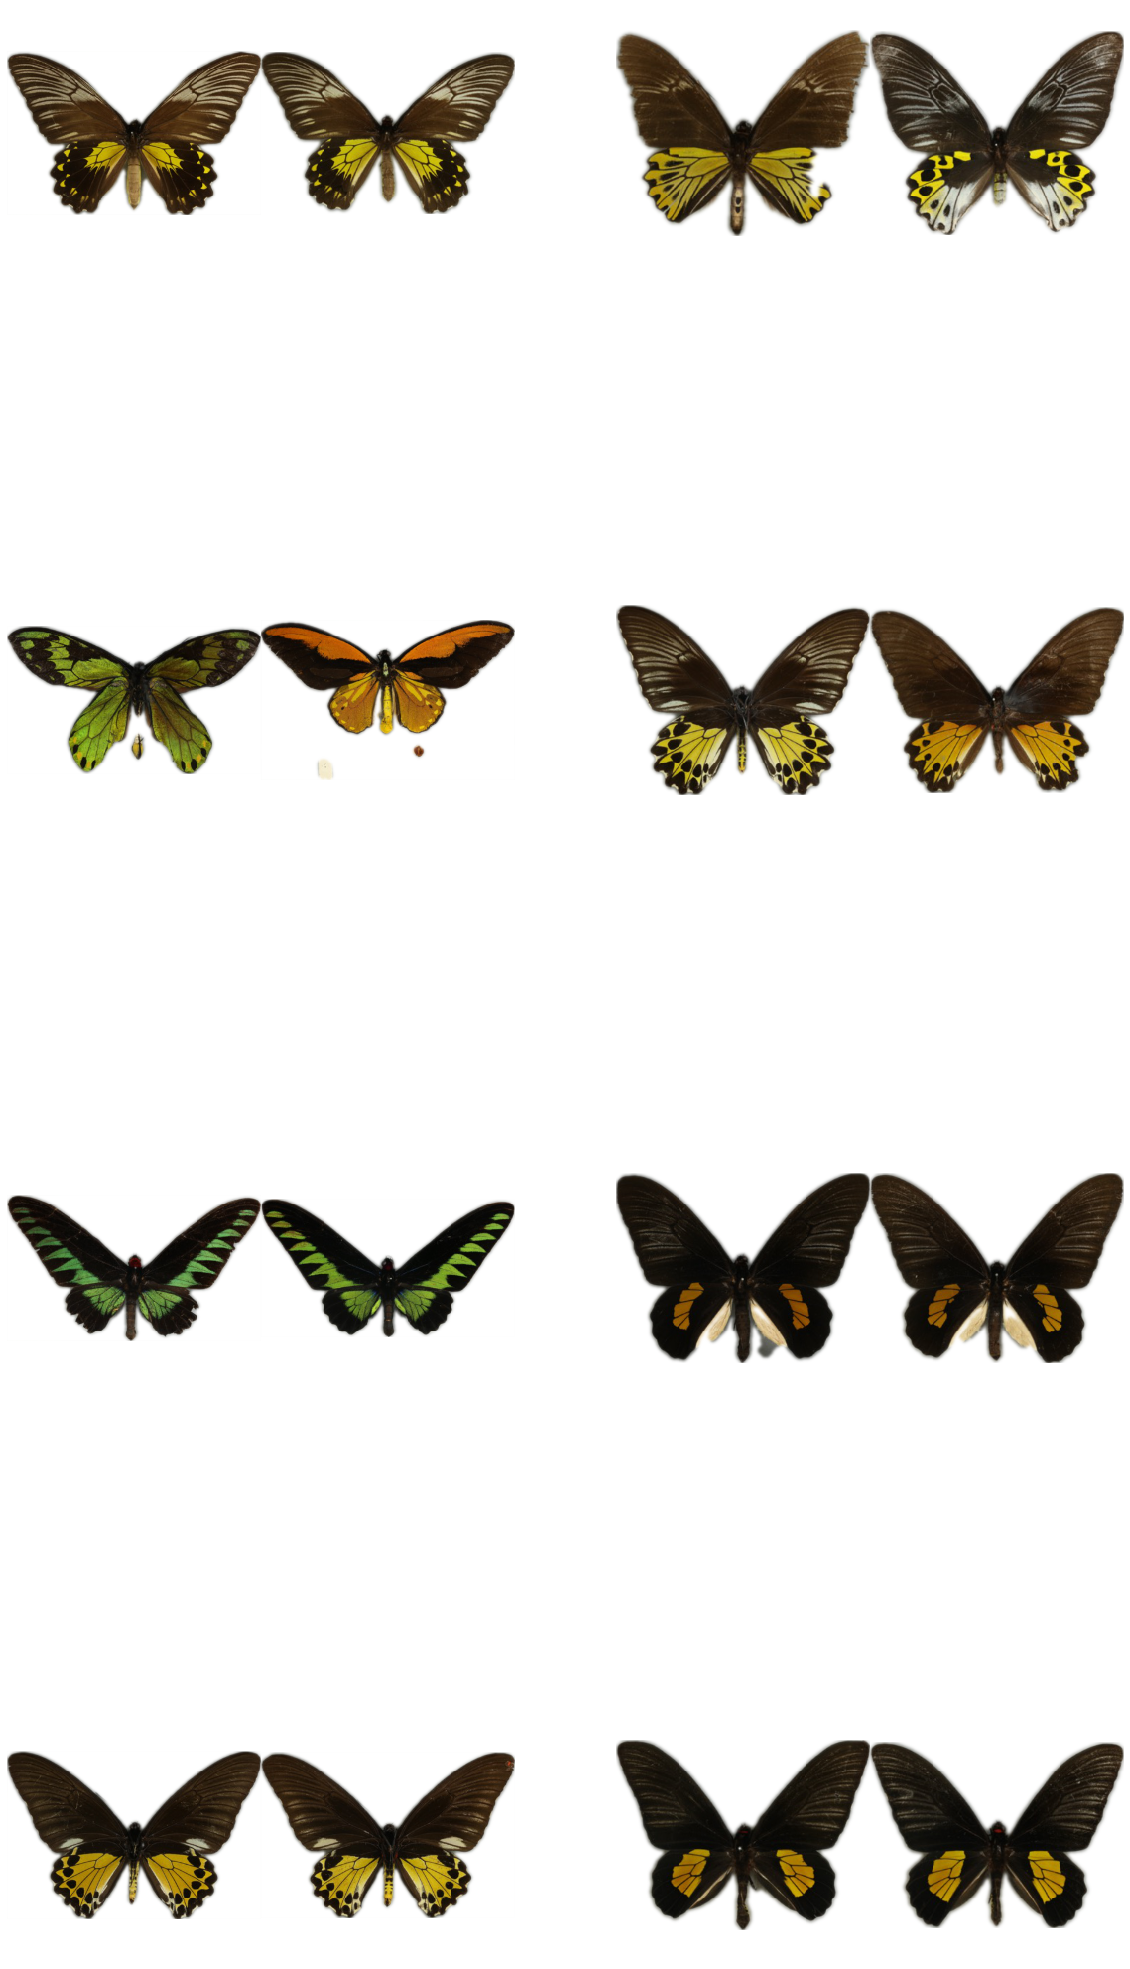

In [45]:
from sklearn.neighbors import NearestNeighbors
from scipy import spatial

Z = z[3]

tree = NearestNeighbors(
    n_neighbors=1, algorithm='ball_tree',
    metric='minkowski')
tree.fit(Z)

plt.figure(figsize=(20,40))

plt.subplot(421)
i = randoms[0]
image_container_orig = Image.new('RGBA', (256*2,256))
neighs = tree.kneighbors([Z[i]],2, return_distance=False)
img = images[neighs[0][0]]
neighbor = images[neighs[0][1]]
image_container_orig.paste(Image.fromarray(img), (0, 0))
image_container_orig.paste(Image.fromarray(neighbor), (256, 0))
plt.imshow(image_container_orig)
plt.axis('off')
    
plt.subplot(422)
i = randoms[1]
image_container_orig = Image.new('RGBA', (256*2,256))
neighs = tree.kneighbors([Z[i]],2, return_distance=False)
img = images[neighs[0][0]]
neighbor = images[neighs[0][1]]
image_container_orig.paste(Image.fromarray(img), (0, 0))
image_container_orig.paste(Image.fromarray(neighbor), (256, 0))
plt.imshow(image_container_orig)
plt.axis('off')

plt.subplot(423)
i = randoms[2]
image_container_orig = Image.new('RGBA', (256*2,256))
neighs = tree.kneighbors([Z[i]],2, return_distance=False)
img = images[neighs[0][0]]
neighbor = images[neighs[0][1]]
image_container_orig.paste(Image.fromarray(img), (0, 0))
image_container_orig.paste(Image.fromarray(neighbor), (256, 0))
plt.imshow(image_container_orig)
plt.axis('off')

plt.subplot(424)
i = randoms[3]
image_container_orig = Image.new('RGBA', (256*2,256))
neighs = tree.kneighbors([Z[i]],2, return_distance=False)
img = images[neighs[0][0]]
neighbor = images[neighs[0][1]]
image_container_orig.paste(Image.fromarray(img), (0, 0))
image_container_orig.paste(Image.fromarray(neighbor), (256, 0))
plt.imshow(image_container_orig)
plt.axis('off')

plt.subplot(425)
i = randoms[4]
image_container_orig = Image.new('RGBA', (256*2,256))
neighs = tree.kneighbors([Z[i]],2, return_distance=False)
img = images[neighs[0][0]]
neighbor = images[neighs[0][1]]
image_container_orig.paste(Image.fromarray(img), (0, 0))
image_container_orig.paste(Image.fromarray(neighbor), (256, 0))
plt.imshow(image_container_orig)
plt.axis('off')

plt.subplot(426)
i = randoms[5]
image_container_orig = Image.new('RGBA', (256*2,256))
neighs = tree.kneighbors([Z[i]],2, return_distance=False)
img = images[neighs[0][0]]
neighbor = images[neighs[0][1]]
image_container_orig.paste(Image.fromarray(img), (0, 0))
image_container_orig.paste(Image.fromarray(neighbor), (256, 0))
plt.imshow(image_container_orig)
plt.axis('off')

plt.subplot(427)
i = randoms[6]
image_container_orig = Image.new('RGBA', (256*2,256))
neighs = tree.kneighbors([Z[i]],2, return_distance=False)
img = images[neighs[0][0]]
neighbor = images[neighs[0][1]]
image_container_orig.paste(Image.fromarray(img), (0, 0))
image_container_orig.paste(Image.fromarray(neighbor), (256, 0))
plt.imshow(image_container_orig)
plt.axis('off')

plt.subplot(428)
i = randoms[7]
image_container_orig = Image.new('RGBA', (256*2,256))
neighs = tree.kneighbors([Z[i]],2, return_distance=False)
img = images[neighs[0][0]]
neighbor = images[neighs[0][1]]
image_container_orig.paste(Image.fromarray(img), (0, 0))
image_container_orig.paste(Image.fromarray(neighbor), (256, 0))
plt.imshow(image_container_orig)
plt.axis('off')

fig = plt.gcf()
fig.savefig('NN_z3_bflies_2.png', dpi=300)

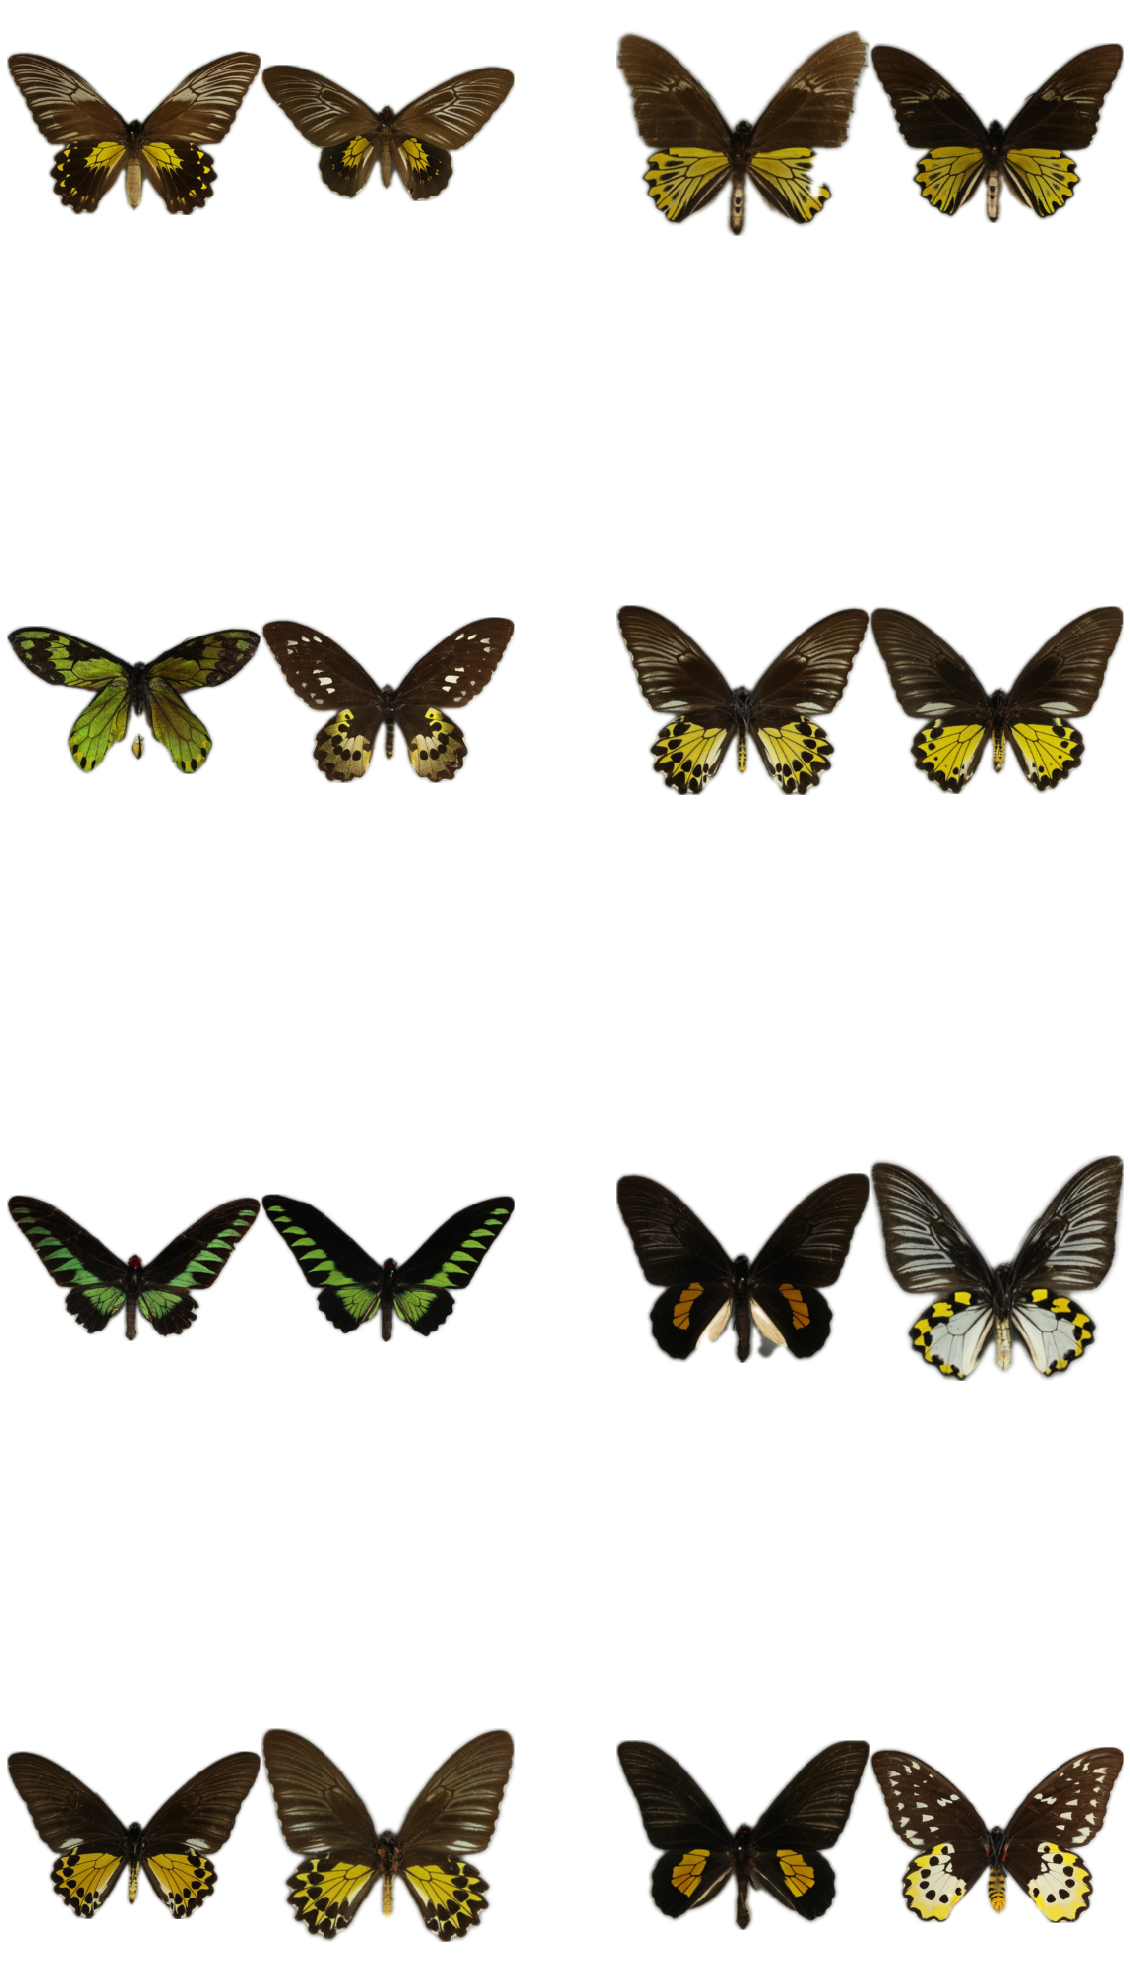

In [46]:
Z = z[2]

tree = NearestNeighbors(
    n_neighbors=1, algorithm='ball_tree',
    metric='minkowski')
tree.fit(Z)

plt.figure(figsize=(20,40))

plt.subplot(421)
i = randoms[0]
image_container_orig = Image.new('RGBA', (256*2,256))
neighs = tree.kneighbors([Z[i]],2, return_distance=False)
img = images[neighs[0][0]]
neighbor = images[neighs[0][1]]
image_container_orig.paste(Image.fromarray(img), (0, 0))
image_container_orig.paste(Image.fromarray(neighbor), (256, 0))
plt.imshow(image_container_orig)
plt.axis('off')
    
plt.subplot(422)
i = randoms[1]
image_container_orig = Image.new('RGBA', (256*2,256))
neighs = tree.kneighbors([Z[i]],2, return_distance=False)
img = images[neighs[0][0]]
neighbor = images[neighs[0][1]]
image_container_orig.paste(Image.fromarray(img), (0, 0))
image_container_orig.paste(Image.fromarray(neighbor), (256, 0))
plt.imshow(image_container_orig)
plt.axis('off')

plt.subplot(423)
i = randoms[2]
image_container_orig = Image.new('RGBA', (256*2,256))
neighs = tree.kneighbors([Z[i]],2, return_distance=False)
img = images[neighs[0][0]]
neighbor = images[neighs[0][1]]
image_container_orig.paste(Image.fromarray(img), (0, 0))
image_container_orig.paste(Image.fromarray(neighbor), (256, 0))
plt.imshow(image_container_orig)
plt.axis('off')

plt.subplot(424)
i = randoms[3]
image_container_orig = Image.new('RGBA', (256*2,256))
neighs = tree.kneighbors([Z[i]],2, return_distance=False)
img = images[neighs[0][0]]
neighbor = images[neighs[0][1]]
image_container_orig.paste(Image.fromarray(img), (0, 0))
image_container_orig.paste(Image.fromarray(neighbor), (256, 0))
plt.imshow(image_container_orig)
plt.axis('off')

plt.subplot(425)
i = randoms[4]
image_container_orig = Image.new('RGBA', (256*2,256))
neighs = tree.kneighbors([Z[i]],2, return_distance=False)
img = images[neighs[0][0]]
neighbor = images[neighs[0][1]]
image_container_orig.paste(Image.fromarray(img), (0, 0))
image_container_orig.paste(Image.fromarray(neighbor), (256, 0))
plt.imshow(image_container_orig)
plt.axis('off')

plt.subplot(426)
i = randoms[5]
image_container_orig = Image.new('RGBA', (256*2,256))
neighs = tree.kneighbors([Z[i]],2, return_distance=False)
img = images[neighs[0][0]]
neighbor = images[neighs[0][1]]
image_container_orig.paste(Image.fromarray(img), (0, 0))
image_container_orig.paste(Image.fromarray(neighbor), (256, 0))
plt.imshow(image_container_orig)
plt.axis('off')

plt.subplot(427)
i = randoms[6]
image_container_orig = Image.new('RGBA', (256*2,256))
neighs = tree.kneighbors([Z[i]],2, return_distance=False)
img = images[neighs[0][0]]
neighbor = images[neighs[0][1]]
image_container_orig.paste(Image.fromarray(img), (0, 0))
image_container_orig.paste(Image.fromarray(neighbor), (256, 0))
plt.imshow(image_container_orig)
plt.axis('off')

plt.subplot(428)
i = randoms[7]
image_container_orig = Image.new('RGBA', (256*2,256))
neighs = tree.kneighbors([Z[i]],2, return_distance=False)
img = images[neighs[0][0]]
neighbor = images[neighs[0][1]]
image_container_orig.paste(Image.fromarray(img), (0, 0))
image_container_orig.paste(Image.fromarray(neighbor), (256, 0))
plt.imshow(image_container_orig)
plt.axis('off')

fig = plt.gcf()
fig.savefig('NN_z2_bflies_2.png', dpi=300)

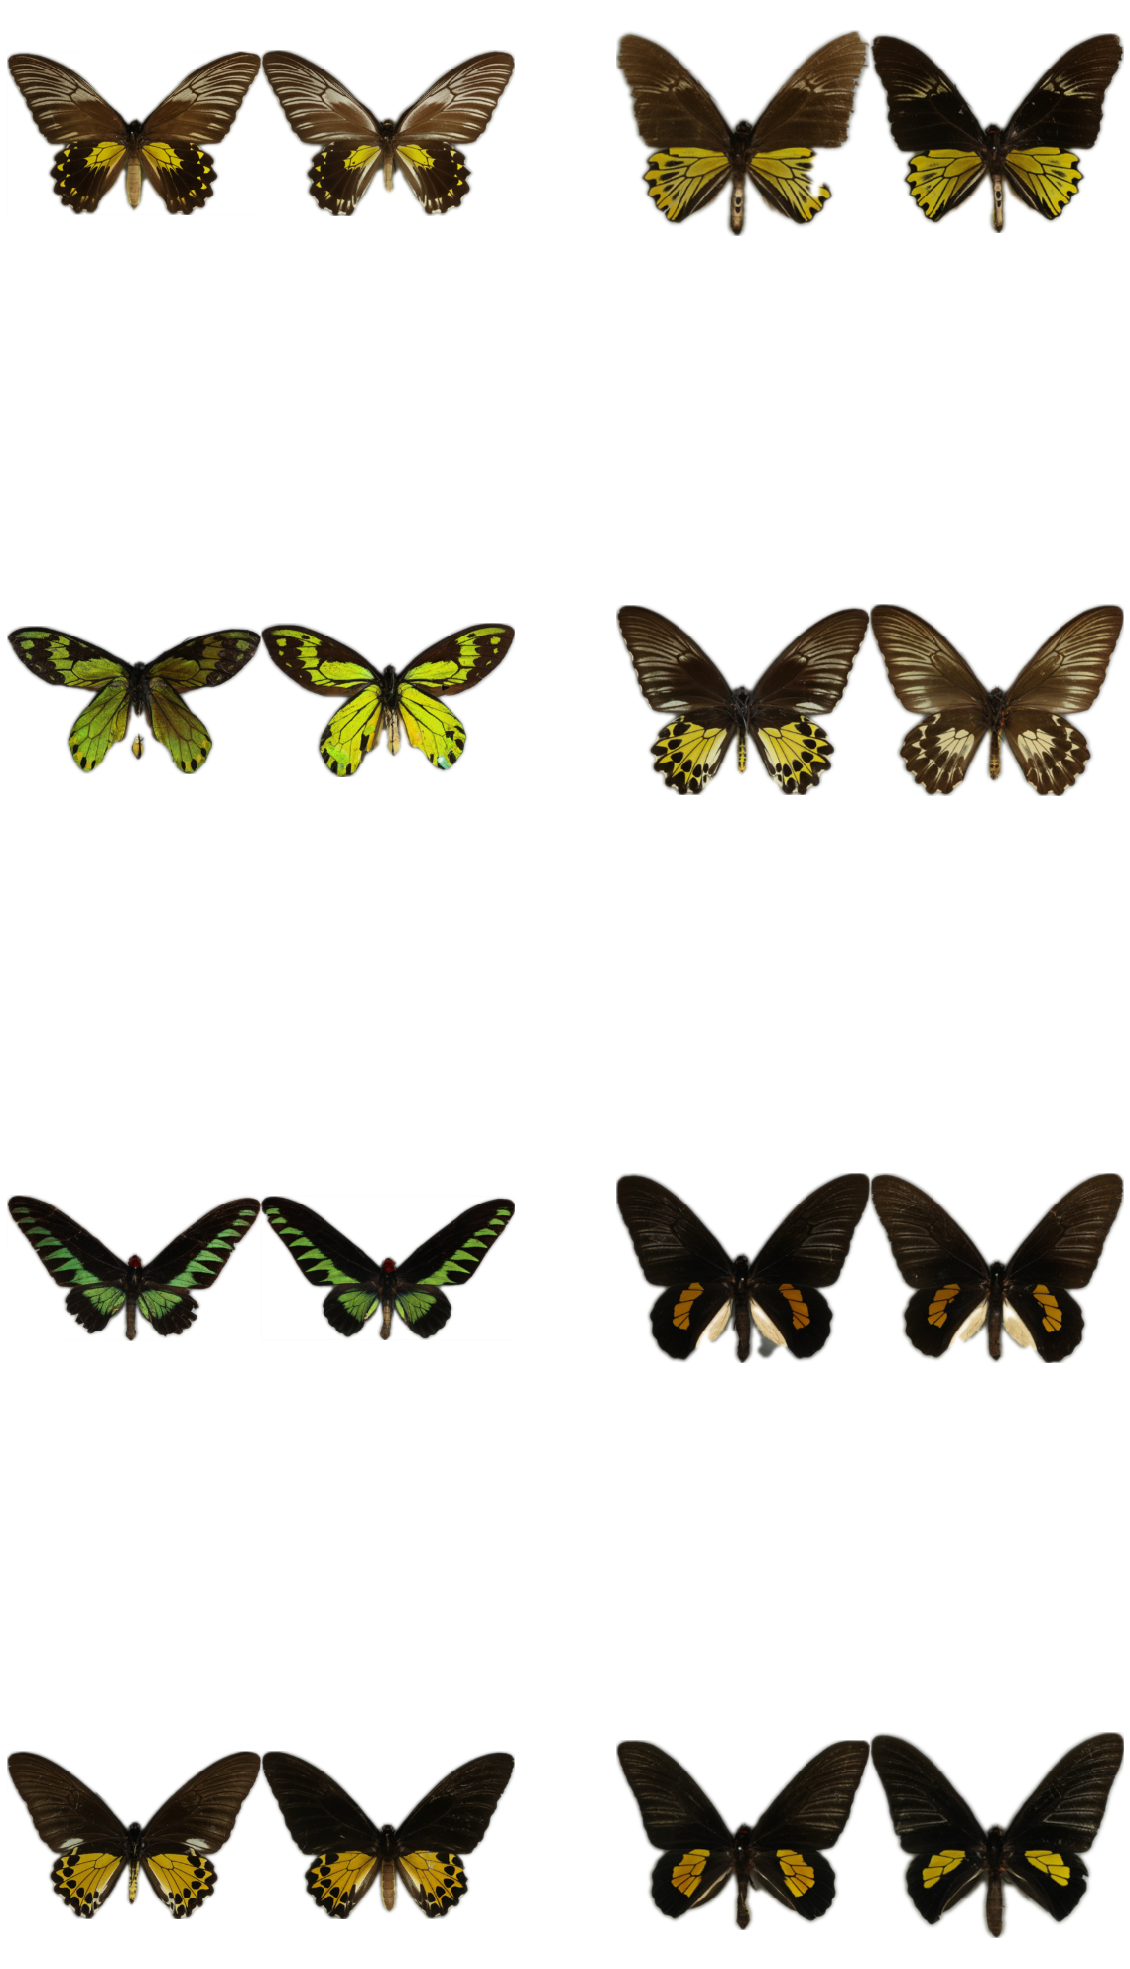

In [47]:
Z = z[1]

tree = NearestNeighbors(
    n_neighbors=1, algorithm='ball_tree',
    metric='minkowski')
tree.fit(Z)

plt.figure(figsize=(20,40))

plt.subplot(421)
i = randoms[0]
image_container_orig = Image.new('RGBA', (256*2,256))
neighs = tree.kneighbors([Z[i]],2, return_distance=False)
img = images[neighs[0][0]]
neighbor = images[neighs[0][1]]
image_container_orig.paste(Image.fromarray(img), (0, 0))
image_container_orig.paste(Image.fromarray(neighbor), (256, 0))
plt.imshow(image_container_orig)
plt.axis('off')
    
plt.subplot(422)
i = randoms[1]
image_container_orig = Image.new('RGBA', (256*2,256))
neighs = tree.kneighbors([Z[i]],2, return_distance=False)
img = images[neighs[0][0]]
neighbor = images[neighs[0][1]]
image_container_orig.paste(Image.fromarray(img), (0, 0))
image_container_orig.paste(Image.fromarray(neighbor), (256, 0))
plt.imshow(image_container_orig)
plt.axis('off')

plt.subplot(423)
i = randoms[2]
image_container_orig = Image.new('RGBA', (256*2,256))
neighs = tree.kneighbors([Z[i]],2, return_distance=False)
img = images[neighs[0][0]]
neighbor = images[neighs[0][1]]
image_container_orig.paste(Image.fromarray(img), (0, 0))
image_container_orig.paste(Image.fromarray(neighbor), (256, 0))
plt.imshow(image_container_orig)
plt.axis('off')

plt.subplot(424)
i = randoms[3]
image_container_orig = Image.new('RGBA', (256*2,256))
neighs = tree.kneighbors([Z[i]],2, return_distance=False)
img = images[neighs[0][0]]
neighbor = images[neighs[0][1]]
image_container_orig.paste(Image.fromarray(img), (0, 0))
image_container_orig.paste(Image.fromarray(neighbor), (256, 0))
plt.imshow(image_container_orig)
plt.axis('off')

plt.subplot(425)
i = randoms[4]
image_container_orig = Image.new('RGBA', (256*2,256))
neighs = tree.kneighbors([Z[i]],2, return_distance=False)
img = images[neighs[0][0]]
neighbor = images[neighs[0][1]]
image_container_orig.paste(Image.fromarray(img), (0, 0))
image_container_orig.paste(Image.fromarray(neighbor), (256, 0))
plt.imshow(image_container_orig)
plt.axis('off')

plt.subplot(426)
i = randoms[5]
image_container_orig = Image.new('RGBA', (256*2,256))
neighs = tree.kneighbors([Z[i]],2, return_distance=False)
img = images[neighs[0][0]]
neighbor = images[neighs[0][1]]
image_container_orig.paste(Image.fromarray(img), (0, 0))
image_container_orig.paste(Image.fromarray(neighbor), (256, 0))
plt.imshow(image_container_orig)
plt.axis('off')

plt.subplot(427)
i = randoms[6]
image_container_orig = Image.new('RGBA', (256*2,256))
neighs = tree.kneighbors([Z[i]],2, return_distance=False)
img = images[neighs[0][0]]
neighbor = images[neighs[0][1]]
image_container_orig.paste(Image.fromarray(img), (0, 0))
image_container_orig.paste(Image.fromarray(neighbor), (256, 0))
plt.imshow(image_container_orig)
plt.axis('off')

plt.subplot(428)
i = randoms[7]
image_container_orig = Image.new('RGBA', (256*2,256))
neighs = tree.kneighbors([Z[i]],2, return_distance=False)
img = images[neighs[0][0]]
neighbor = images[neighs[0][1]]
image_container_orig.paste(Image.fromarray(img), (0, 0))
image_container_orig.paste(Image.fromarray(neighbor), (256, 0))
plt.imshow(image_container_orig)
plt.axis('off')

fig = plt.gcf()
fig.savefig('NN_z1_bflies_2.png', dpi=300)

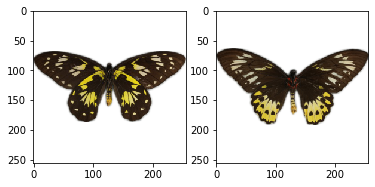

In [76]:
plt.subplot(121)
plt.imshow(images[neighs[0][0]])
plt.subplot(122)
plt.imshow(images[neighs[0][1]])

In [52]:
z[3][0]

array([-0.37800238, -0.09976563,  0.69653493,  0.36587736,  0.18305765,
        0.09617976,  0.82324815, -0.11965492, -0.36493468,  0.93861765],
      dtype=float32)

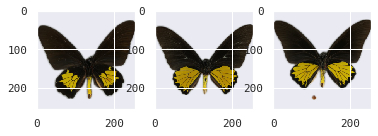

In [51]:
plt.subplot(131)
plt.imshow(images[5245])
plt.subplot(132)
plt.imshow(images[5352])
plt.subplot(133)
plt.imshow(images[6650])

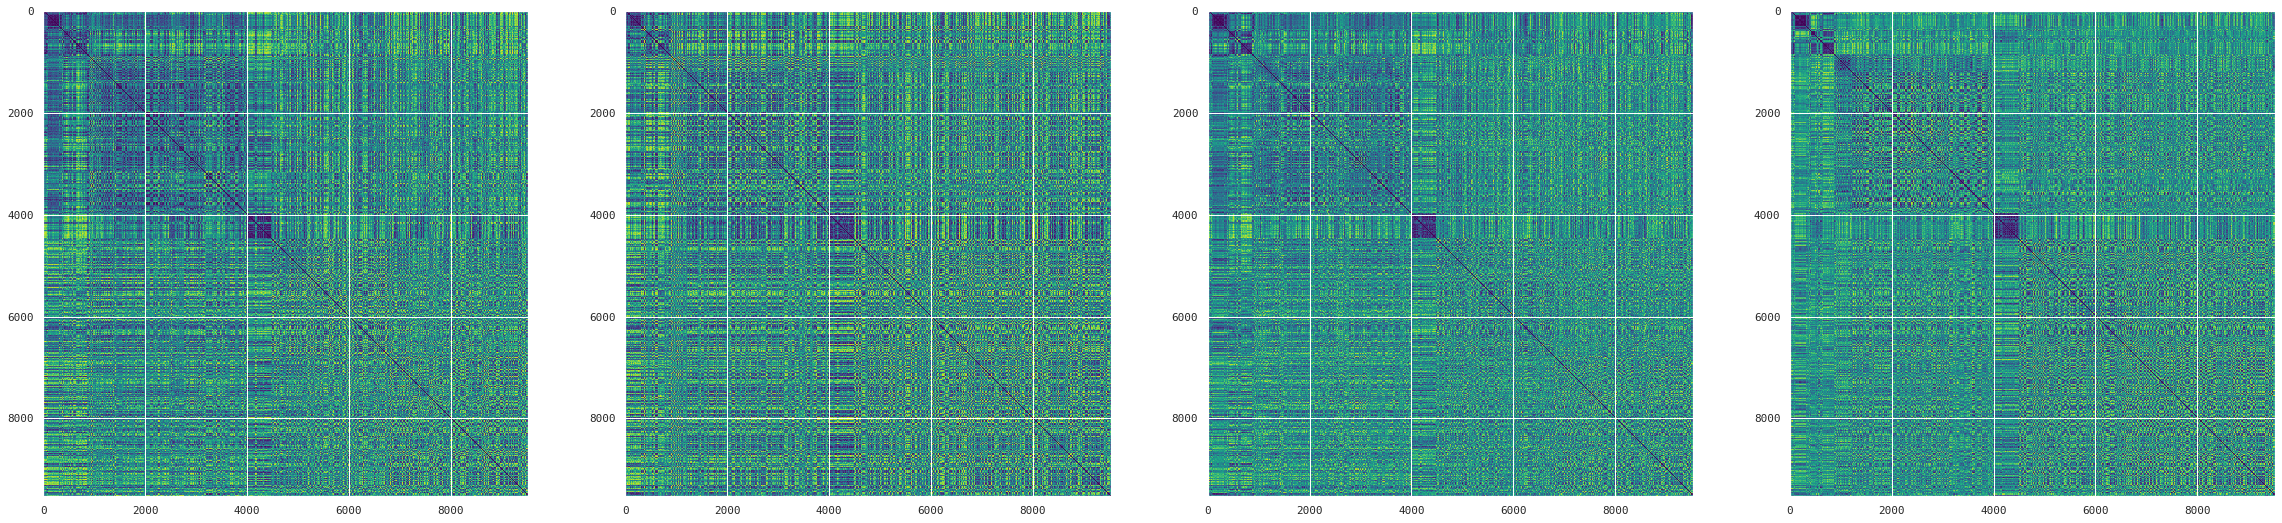

In [28]:
plt.figure(figsize=(40,20))

plt.subplot(141)
X = z[0]

pairwise = pd.DataFrame(
    squareform(pdist(X, metric='cosine')),
)
plt.imshow(pairwise, cmap='viridis')
plt.subplot(142)
X = z[1]

pairwise = pd.DataFrame(
    squareform(pdist(X, metric='cosine')),
)
plt.imshow(pairwise, cmap='viridis')
plt.subplot(143)
X = z[2]

pairwise = pd.DataFrame(
    squareform(pdist(X, metric='cosine')),
)
plt.imshow(pairwise, cmap='viridis')
plt.subplot(144)
X = z[3]

pairwise = pd.DataFrame(
    squareform(pdist(X, metric='cosine')),
)
plt.imshow(pairwise, cmap='viridis')

In [27]:
linkage = hc.linkage(squareform(pdist(X, metric='cosine')))

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.


In [36]:
linkage[0]

array([4.48700000e+03, 4.98500000e+03, 1.76352012e+00, 2.00000000e+00])

In [33]:
linkage_0 = hc.linkage(squareform(pdist(z[0], metric='cosine')))

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.


In [35]:
linkage_0[0]

array([4.08900000e+03, 4.28900000e+03, 1.87263577e+00, 2.00000000e+00])

In [ ]:
import pandas as pd, seaborn as sns
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
sns.set(font="monospace")
X = z[0]
DF = pd.DataFrame(squareform(pdist(X, metric='cosine')))
sns.clustermap(DF,metric='cosine')

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/seaborn/matrix.py:624: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/seaborn/matrix.py:595: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


In [15]:
D = pairwise_distances(z[0],metric='cosine')

In [16]:
D.shape

(9531, 9531)

In [9]:
labels = []
images = []
for image, label in data_loader.get_plot_data():
    labels.append(label.numpy().decode('utf8'))
    images.append(image.numpy().astype('uint8'))
images = np.stack(images)
labels = np.array(labels)

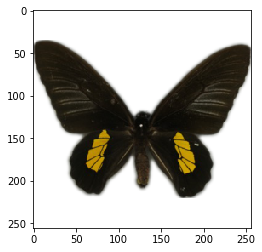

In [10]:
plt.imshow(images[-102])

In [14]:
labels[0]

'Hesperiidae_Artines'

In [13]:
image_output_folder = 'report_again/figures/images/{}'.format(checkpoint_path.split('/')[7])
plot_output_folder = 'report_again/figures/panels{}'.format(checkpoint_path.split('/')[7])
n_latents = 4 
latent_size = 10
Path(image_output_folder).mkdir(parents=True, exist_ok=True)
Path(plot_output_folder).mkdir(parents=True, exist_ok=True)

In [14]:
def make_rand_samples(model, n_samples=9, num_steps=300, mu=0., sigma=1.):
    output_folder = os.path.join(image_output_folder, 'explore_latents/random_normal/frames')
    Path(output_folder).mkdir(parents=True, exist_ok=True)
    sample =  [
        np.random.multivariate_normal([mu] * latent_size,np.diag([sigma] * latent_size), n_samples)
        ] * n_latents

    for z in range(n_latents):
        for t in range(num_steps):
            sample[z] = np.random.multivariate_normal(
                [mu] * latent_size, np.diag([sigma] * latent_size), n_samples)
            generated = model.get_layer('decoder').predict(sample, batch_size=10)
            generated = generated.reshape((n_samples, 256, 256,3))
            image_container = Image.new('RGB', (256*3,256*3))
            locs = list(product(range(int(np.sqrt(n_samples))),range(int(np.sqrt(n_samples)))))
            for i in range(n_samples):
                img = generated[i]
                j, k = locs[i]
                img = 255 * np.array(img)
                img = img.astype(np.uint8)
                image_container.paste(Image.fromarray(img.astype('uint8')), (k*256, j*256))
            image_container.save(os.path.join(output_folder,'z{}_{:03d}.png'.format(z,t)))


def make_traversal_from_zeros(model, n_samples=1, num_steps=11):
    output_folder = os.path.join(image_output_folder, 'explore_latents/traversal')
    Path(output_folder).mkdir(parents=True, exist_ok=True)
    multipliers = np.linspace(-3,3,num=num_steps)

    for z_i in range(4):
        image_container = Image.new('RGB', (256*num_steps,256*latent_size))
        for z_i_j in range(latent_size):
            for s in range(num_steps):
                sample = [np.array([[0] * latent_size]),
                        np.array([[0] * latent_size]),
                        np.array([[0] * latent_size]),
                        np.array([[0] * latent_size])]
                
                sample[z_i][0][z_i_j] = multipliers[s]
                generated = model.get_layer('decoder').predict(sample, batch_size=1)
                generated = generated.reshape((256, 256,3))
                img = 255 * np.array(generated)
                img = img.astype(np.uint8)
                image_container.paste(Image.fromarray(img.astype('uint8')), (s*256, z_i_j*256))
        image_container.save(os.path.join(output_folder,'z{}.png'.format(z_i)))


def make_traversal_from_sample(model, z, n_samples=1, num_steps=11, sample_id=0):
    output_folder = os.path.join(image_output_folder, 'explore_latents/traversal')
    Path(output_folder).mkdir(parents=True, exist_ok=True)
    multipliers = np.linspace(-3,3,num=num_steps)
    encoded_sample = [z_i[sample_id] for z_i in z]

    for z_i in range(4):
        image_container = Image.new('RGB', (256*num_steps,256*latent_size))
        for z_i_j in range(latent_size):
            for s in range(num_steps):
                sample = [np.array([encoded_sample[0]]),
                      np.array([encoded_sample[1]]),
                      np.array([encoded_sample[2]]),
                      np.array([encoded_sample[3]])]
                
                sample[z_i][0][z_i_j] = multipliers[s]
                generated = model.get_layer('decoder').predict(sample, batch_size=1)
                generated = generated.reshape((256, 256, 3))
                img = 255 * np.array(generated)
                img = img.astype(np.uint8)
                image_container.paste(Image.fromarray(img.astype('uint8')), (s*256, z_i_j*256))
        image_container.save(os.path.join(output_folder,'{}sample{}.png'.format(sample_id, z_i)))


In [15]:
make_rand_samples(model.model)

In [16]:
make_traversal_from_sample(model.model, z, sample_id=-102)

In [17]:
make_traversal_from_zeros(model.model)

In [16]:
# vision_engine_embedding1 = TSNE(callbacks=ErrorLogger(), n_jobs=-1, learning_rate=len(z[0])/12, exaggeration=4).fit(np.array(z[0]))
# vision_engine_embedding2 = TSNE(callbacks=ErrorLogger(), n_jobs=-1, learning_rate=len(z[1])/12, exaggeration=4).fit(np.array(z[1]))
# vision_engine_embedding3 = TSNE(callbacks=ErrorLogger(), n_jobs=-1, learning_rate=len(z[2])/12, exaggeration=4).fit(np.array(z[2]))
# vision_engine_embedding4 = TSNE(callbacks=ErrorLogger(), n_jobs=-1, learning_rate=len(z[3])/12, exaggeration=4).fit(np.array(z[3]))

In [18]:
vision_engine_embedding1 = TSNE(callbacks=ErrorLogger(), n_jobs=-1).fit(np.array(z[0]))
vision_engine_embedding2 = TSNE(callbacks=ErrorLogger(), n_jobs=-1).fit(np.array(z[1]))
vision_engine_embedding3 = TSNE(callbacks=ErrorLogger(), n_jobs=-1).fit(np.array(z[2]))
vision_engine_embedding4 = TSNE(callbacks=ErrorLogger(), n_jobs=-1).fit(np.array(z[3]))

Iteration   50, KL divergence  6.8133, 50 iterations in 4.7985 sec
Iteration  100, KL divergence  6.7227, 50 iterations in 4.9779 sec
Iteration  150, KL divergence  6.6758, 50 iterations in 4.8346 sec
Iteration  200, KL divergence  6.6756, 50 iterations in 4.9366 sec
Iteration  250, KL divergence  6.6756, 50 iterations in 4.9256 sec
Iteration   50, KL divergence  5.1828, 50 iterations in 4.9276 sec
Iteration  100, KL divergence  4.9716, 50 iterations in 4.9126 sec
Iteration  150, KL divergence  4.8179, 50 iterations in 5.0165 sec
Iteration  200, KL divergence  4.6917, 50 iterations in 4.9269 sec
Iteration  250, KL divergence  4.5900, 50 iterations in 4.9393 sec
Iteration  300, KL divergence  4.5076, 50 iterations in 4.9509 sec
Iteration  350, KL divergence  4.4387, 50 iterations in 4.8436 sec
Iteration  400, KL divergence  4.3792, 50 iterations in 4.9509 sec
Iteration  450, KL divergence  4.3271, 50 iterations in 4.9808 sec
Iteration  500, KL divergence  4.2809, 50 iterations in 5.1723

In [19]:
plt.figure(figsize=(80,40))

classnames, indices = np.unique( labels, return_inverse=True)
N = len(classnames)
cmap = plt.cm.rainbow
bounds = np.linspace(0,N,N+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

plt.subplot(241)
embedding = vision_engine_embedding1
imscatter(embedding[:, 0], embedding[:, 1], images, zoom=0.40);


plt.subplot(242)
embedding = vision_engine_embedding2
imscatter(embedding[:, 0], embedding[:, 1], images, zoom=0.40);

plt.subplot(243)
embedding = vision_engine_embedding3
imscatter(embedding[:, 0], embedding[:, 1], images, zoom=0.40);

plt.subplot(244)
embedding = vision_engine_embedding4
imscatter(embedding[:, 0], embedding[:, 1], images, zoom=0.40);

plt.subplot(245)
embedding = vision_engine_embedding1
plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.5,
        c=indices, cmap=cmap, norm=norm, s=400)

plt.subplot(246)
embedding = vision_engine_embedding2
plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.5,
        c=indices, cmap=cmap, norm=norm, s=400)

plt.subplot(247)
embedding = vision_engine_embedding3
plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.5,
        c=indices, cmap=cmap, norm=norm, s=400)

plt.subplot(248)
embedding = vision_engine_embedding4
plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.5,
        c=indices, cmap=cmap, norm=norm, s=400)

fig = plt.gcf()
fig.savefig(os.path.join(
    plot_output_folder,
    'Zs_{}_real{}_gen{}.pdf'.format(
        checkpoint_path.split('/')[7],
        config.data_loader.use_real,
        config.data_loader.use_generated
    )
)
           )
fig.savefig(os.path.join(
    plot_output_folder,
    'Zs_{}_real{}_gen{}.png'.format(
        checkpoint_path.split('/')[7],
        config.data_loader.use_real,
        config.data_loader.use_generated
    )
)
           )
plt.clf()

<Figure size 5760x2880 with 0 Axes>

In [17]:
def make_perceptual_loss_model(input_shape, layers=[13]):
    loss_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape)
    loss_model.trainable = False
    for layer in loss_model.layers:
        layer.trainable = False
    loss_layers = [ loss_model.layers[i].output
                for i in layers
                ]
    return Model(loss_model.inputs,loss_layers)

# @numba.jit(nopython=True, parallel=True)
# def calculate_perceptual_distances(X):
#     dists = np.zeros((989,989))
#     for layer in X:
#         layer.shape
#         for i in range(layer.shape[0]):
#             for j in range(layer.shape[0]):
#                 shape = (layer[i].shape[0]*layer[i].shape[1]*layer[i].shape[2])
#                 sqr = np.square(layer[i] - layer[j])
#                 sm = np.sum(sqr)
#                 val = sm / shape
#                 dists[i,j] =+ val
#     return dists


@numba.jit(nopython=True, parallel=True)
def calculate_perceptual_distances(X):
    norm_dists = np.zeros((len(X[0]),len(X)))
    for i in range(len(X)):
        for j in range(len(X[0])):
            norm_dists[j, i] = np.linalg.norm(X[i][j].flatten())
    return norm_dists

In [18]:
perceptual_model = make_perceptual_loss_model((256,256,3))

In [41]:
perception = perceptual_model.predict_generator(data_loader.get_test_data())
perceptual_dists = calculate_perceptual_distances(perception)
perceptual_embedding = TSNE(callbacks=ErrorLogger(), n_jobs=-1).fit(perceptual_dists.T)

Iteration   50, KL divergence  3.0718, 50 iterations in 0.6470 sec
Iteration  100, KL divergence  3.0712, 50 iterations in 0.7494 sec
Iteration  150, KL divergence  3.0713, 50 iterations in 0.6495 sec
Iteration  200, KL divergence  3.0713, 50 iterations in 0.6749 sec
Iteration  250, KL divergence  3.0713, 50 iterations in 0.6695 sec
Iteration   50, KL divergence  1.2616, 50 iterations in 0.6714 sec
Iteration  100, KL divergence  1.1273, 50 iterations in 0.6626 sec
Iteration  150, KL divergence  1.0859, 50 iterations in 0.7806 sec
Iteration  200, KL divergence  1.0728, 50 iterations in 1.0888 sec
Iteration  250, KL divergence  1.0675, 50 iterations in 1.4626 sec
Iteration  300, KL divergence  1.0640, 50 iterations in 1.1651 sec
Iteration  350, KL divergence  1.0605, 50 iterations in 1.1297 sec
Iteration  400, KL divergence  1.0597, 50 iterations in 1.9686 sec
Iteration  450, KL divergence  1.0568, 50 iterations in 1.4102 sec
Iteration  500, KL divergence  1.0555, 50 iterations in 1.3890

In [30]:
raw_image_embedding = TSNE(callbacks=ErrorLogger(), n_jobs=-1).fit(images.reshape((len(images),256*256*4)))

/home/etheredge/miniconda3/envs/VisionEngine/lib/python3.7/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Iteration   50, KL divergence  2.2265, 50 iterations in 0.6854 sec
Iteration  100, KL divergence  1.8970, 50 iterations in 0.6738 sec
Iteration  150, KL divergence  1.8514, 50 iterations in 0.6448 sec
Iteration  200, KL divergence  1.9441, 50 iterations in 0.6832 sec
Iteration  250, KL divergence  1.8216, 50 iterations in 0.6393 sec
Iteration   50, KL divergence  1.4754, 50 iterations in 0.6787 sec
Iteration  100, KL divergence  1.4580, 50 iterations in 0.6798 sec
Iteration  150, KL divergence  1.4568, 50 iterations in 0.6827 sec
Iteration  200, KL divergence  1.4564, 50 iterations in 0.6766 sec
Iteration  250, KL divergence  1.4563, 50 iterations in 0.6627 sec
Iteration  300, KL divergence  1.4562, 50 iterations in 0.6657 sec
Iteration  350, KL divergence  1.4561, 50 iterations in 0.6627 sec
Iteration  400, KL divergence  1.4561, 50 iterations in 0.6699 sec
Iteration  450, KL divergence  1.4561, 50 iterations in 0.6550 sec
Iteration  500, KL divergence  1.4561, 50 iterations in 0.6645

In [56]:
classnames, indices = np.unique( labels, return_inverse=True)
N = len(classnames)
cmap = plt.cm.rainbow
bounds = np.linspace(0,N,N+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

plt.figure(figsize=(60,40))

plt.subplot(231)
embedding = raw_image_embedding
imscatter(embedding[:, 0], embedding[:, 1], images, zoom=0.40);
plt.subplot(234)
plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.5,
        c=indices, cmap=cmap, norm=norm, s=400)

plt.subplot(232)
embedding = perceptual_embedding
imscatter(embedding[:, 0], embedding[:, 1], images, zoom=0.40);
plt.subplot(235)
plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.5,
        c=indices, cmap=cmap, norm=norm, s=400)

plt.subplot(233)
embedding = vision_engine_embedding
imscatter(embedding[:, 0], embedding[:, 1], images, zoom=0.40);
plt.subplot(236)
plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.5,
        c=indices, cmap=cmap, norm=norm, s=400)

fig = plt.gcf()
fig.savefig(os.path.join(
    plot_output_folder,
    'compare_methods_{}.pdf'.format(
        checkpoint_path.split('/')[7]
    )
)
           )
fig.savefig(os.path.join(
    plot_output_folder,
    'compare_methods_{}.png'.format(
        checkpoint_path.split('/')[7]
    )
)
           )
plt.clf()

<Figure size 4320x2880 with 0 Axes>